In [1]:
import numpy as np
import pandas as pd

from contextualized.easy import ContextualizedRegressor

In [2]:
# Make simulation data
C_train = pd.DataFrame(np.random.uniform(0, 1, size=(100, 1)))
X_train = pd.DataFrame(np.random.uniform(0, 0.5, size=(100, 1)))
Y_train = pd.DataFrame(C_train.values*X_train.values).values

In [3]:
# So simple
model = ContextualizedRegressor(n_bootstraps=2)
model.fit(C_train.values, X_train.values, Y_train, max_epochs=10, learning_rate=1e-2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params
---------------------------------------------
0 | metamodel | NaiveMetamodel | 102   
---------------------------------------------
102       Trainable params
0         Non-trainable params
102       Total params
0.000     Total estimated model params size (MB)


Received unknown keyword argument n_bootstraps, probably ignoring.


Sanity Checking: 0it [00:00, ?it/s]

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/experiments/Easy-demo/lightning_logs/version_18/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type           | Params
---------------------------------------------
0 | metamodel | NaiveMetamodel | 102   
---------------------------------------------
102       Trainable params
0         Non-trainable params
102       Total params
0.000     Total estimated model params

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 80it [00:00, ?it/s]

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 80it [00:00, ?it/s]

Text(0, 0.5, 'Predicted Value')

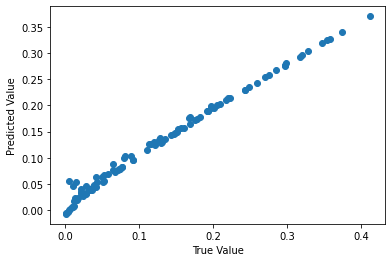

In [4]:
# Look at the model predictions.
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(Y_train, model.predict(C_train.values, X_train.values))
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

Predicting: 80it [00:00, ?it/s]

Predicting: 80it [00:00, ?it/s]

Text(0, 0.5, 'Predicted Value')

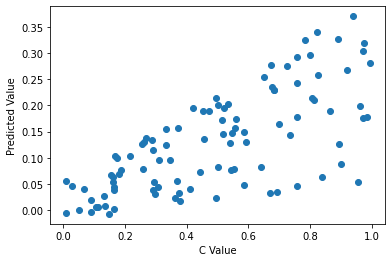

In [5]:
plt.scatter(C_train, model.predict(C_train.values, X_train.values))
plt.xlabel("C Value")
plt.ylabel("Predicted Value")

Predicting: 80it [00:00, ?it/s]

Predicting: 80it [00:00, ?it/s]

Text(0, 0.5, 'Predicted Value')

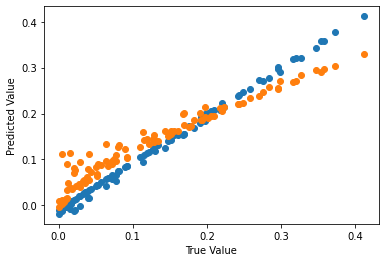

In [6]:
# Check what the bootstrap models learned.
model_preds = model.predict(C_train.values, X_train.values, individual_preds=True)
for pred in model_preds:
    plt.scatter(Y_train, pred)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

Predicting: 80it [00:00, ?it/s]

Predicting: 80it [00:00, ?it/s]

Predicting: 80it [00:00, ?it/s]

Predicting: 80it [00:00, ?it/s]

(2, 100, 1, 1)


Text(0, 0.5, 'Parameter value')

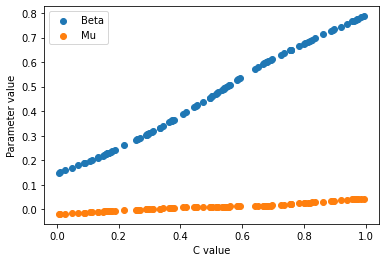

In [8]:
# Get model parameters.
betas, mus = model.predict_params(C_train.values, individual_preds=False)
plt.scatter(C_train.values, betas, label='Beta')
plt.scatter(C_train.values, mus, label='Mu')
plt.legend()
plt.xlabel("C value")
plt.ylabel("Parameter value")